In [1]:
# Installing tensorflow
!pip install tensorflow

In [20]:
# Import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [21]:
# Loading the dataset from the UCI Machine Learning Repository
datapath = "https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-only.data"
column_names = ["AtRisk", "ThermalDistress", "Temperature", "LeakCheckPressure", "TemporalFlightOrder"]

dataset = pd.read_csv(datapath, names = column_names, na_values = "?", comment = "\t", sep = " ", skipinitialspace = True)
dataset.tail()

,AtRisk,ThermalDistress,Temperature,LeakCheckPressure,TemporalFlightOrder
18,6,0,76,200,19
19,6,0,79,200,20
20,6,0,75,200,21
21,6,0,76,200,22
22,6,1,58,200,23


In [22]:
# Dropping any null values in the dataset
dataset = dataset.dropna()

In [23]:
# Creating the training and testing datasets from the main dataset
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

# Getting the statistics of the training dataset
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AtRisk,18.0,6.000000,0.000000,6.0,6.00,6.0,6.00,6.0
ThermalDistress,18.0,0.388889,0.607685,0.0,0.00,0.0,1.00,2.0
Temperature,18.0,69.166667,7.485280,53.0,67.00,70.0,74.50,81.0
LeakCheckPressure,18.0,155.555556,66.174655,50.0,100.00,200.0,200.00,200.0
TemporalFlightOrder,18.0,12.333333,6.615490,2.0,7.25,11.5,17.75,23.0


In [24]:
# Splitting the lables from the training and testing datasets
train_labels = train_dataset.pop("Temperature")
test_labels = test_dataset.pop("Temperature")

In [25]:
# Creating the normalization layer for the neural network model
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_dataset))
print(normalizer.mean.numpy())

[[  6.          0.3888889 155.55556    12.333333 ]]


In [26]:
# Getting an array of the values of the pressure
pressure = np.array(train_dataset["LeakCheckPressure"])

# Getting the normalization of the pressure values
pressure_normalizer = layers.Normalization(input_shape = [1,], axis = None)
pressure_normalizer.adapt(pressure)

In [27]:
# This function will create a model containing 4 total layers
def create_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation = "relu"),
        layers.Dense(64, activation = "relu"),
        layers.Dense(1)
    ])
    
    model.compile(loss = "mean_absolute_error", optimizer = tf.keras.optimizers.Adam(0.001))
    return model

In [28]:
# Create and show summary of model of the pressure values
pressure_model = create_model(pressure_normalizer)
pressure_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                128       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [29]:
# Run the model for 1000 epochs, perform validations split at 20% of the values
history = pressure_model.fit(train_dataset["LeakCheckPressure"], train_labels, validation_split = 0.2, verbose = 0, 
                             epochs = 1000)

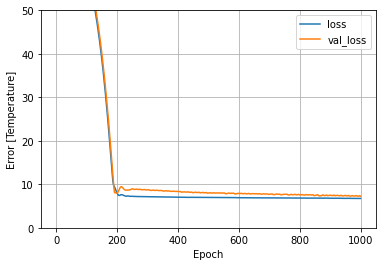

In [30]:
# This function will plot the loss of the model
def plot_loss(history):
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.ylim([0, 50])
    plt.xlabel("Epoch")
    plt.ylabel("Error [Temperature]")
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [31]:
# Adding the pressure model to the test results and converting it to a dataframe
model_results = {}
model_results["pressure_model"] = pressure_model.evaluate(test_dataset["LeakCheckPressure"], test_labels, verbose = 0)
pd.DataFrame(model_results, index = ["Mean absolute error [Temperature]"]).T

,Mean absolute error [Temperature]
pressure_model,4.26127


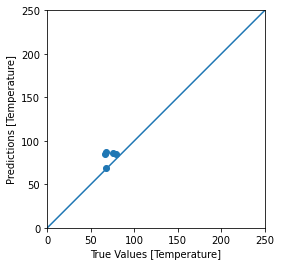

In [32]:
# Using the model to make predictions based on the testing dataset
test_predictions = pressure_model.predict(np.array(test_dataset).flatten()).flatten()

a = plt.axes(aspect = "equal")
plt.scatter(test_labels, test_predictions[:5])
plt.xlabel("True Values [Temperature]")
plt.ylabel("Predictions [Temperature]")
lims = [0, 250]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

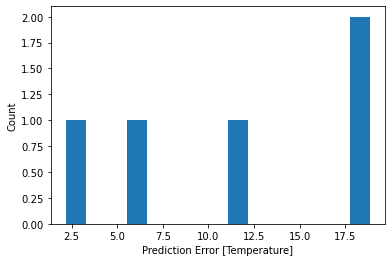

In [33]:
# Find and plot the error of the predictions
error = test_predictions[:5] - test_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [Temperature]")
_ = plt.ylabel("Count")